In [1]:
import numpy as np
import gym
import time
import json
from matplotlib import pyplot as plt

In [2]:
# ARS Agent
class ARSLunar():
    def __init__(self):
        self.env = gym.make("LunarLander-v2")
        self.epochs = 1000
        self.episodes = 1000
        self.alpha = 0.02
        self.noise = 0.03
        self.num = np.zeros(8)
        self.mean = np.zeros(8)
        self.diff = np.zeros(8)
        self.var = np.zeros(8)
        self.policy = np.zeros((4, 8))

    def _track(self, _val):
        self.num += 1.
        last_mean = self.mean.copy()
        self.mean += (_val - self.mean) / self.num
        self.diff += (_val - last_mean) * (_val - self.mean)
        self.var = (self.diff / self.num).clip(min=1e-2)

    def _normalize(self, _params):
        mean = self.mean
        std = np.sqrt(self.var)
        return (_params - mean) / std

    def _evaluate(self, _params, _deltas=1, _trend=0):           
        if _trend == 1:
            return (self.policy + self.noise * _deltas).dot(_params)

        if _trend == -1:
            return (self.policy - self.noise * _deltas).dot(_params)
        
        return self.policy.dot(_params)

    def _update(self, _updates, _reward_std):
        step = np.zeros(self.policy.shape)
        for p, n, d in _updates:
            step += (p - n) * d

        self.policy += self.alpha / (10 * _reward_std) * step

    def _explore(self, _deltas=1, _trend=0):
        state = self.env.reset()
        end = False
        eps = 0.
        rv = 0

        while not end and eps < self.episodes:
            self._track(state)
            state = self._normalize(state)
            action = np.argmax(self._evaluate(state, _deltas, _trend))
            state, reward, end, _ = self.env.step(action)
            reward = max(min(reward, 1), -1)
            rv += reward
            eps += 1

        return rv
    
    def _random_search(self):
        deltas = [np.random.randn(*self.policy.shape) for _ in range(15)]
        pos = [0] * 15
        neg = [0] * 15

        for idx in range(15):
            pos[idx] = self._explore(deltas[idx], 1)

        for idx in range(15):
            neg[idx] = self._explore(deltas[idx], -1)

        rewards = np.array(pos + neg)
        reward_std = rewards.std()

        res_table = {k: max(r_pos, r_neg) for k, (r_pos, r_neg) in enumerate(zip(pos, neg))}
        sorted_res_table = sorted(res_table.keys(), key=lambda k: res_table[k], reverse=True)[:10]
        updates = [(pos[k], neg[k], deltas[k]) for k in sorted_res_table]

        self._update(updates, reward_std)
        rv = self._explore()

        return rv

    def run(self):
        start = time.time()
        rv = []

        for itr in range(self.epochs):
            rewards = self._random_search()
            time_stamp =  time.time() - start
           
            rv.append((itr, rewards, time_stamp))

            if itr % 10 == 0: 
                print('Iteration:', itr, 'Rewards:', rewards)
    
        return rv


In [3]:
# Run Agent
ars_agent = ARSLunar()
data = ars_agent.run()

Iteration: 0 Rewards: -53.801797410051144
Iteration: 10 Rewards: -0.1193232484834752
Iteration: 20 Rewards: 27.805873972772947
Iteration: 30 Rewards: -14.017894381167107
Iteration: 40 Rewards: 19.653887651792445
Iteration: 50 Rewards: 13.324385963535065
Iteration: 60 Rewards: 29.569747109611285
Iteration: 70 Rewards: 10.423494946558366
Iteration: 80 Rewards: 5.646732129383107
Iteration: 90 Rewards: 17.264129287471658
Iteration: 100 Rewards: 38.95130384715281
Iteration: 110 Rewards: 24.364471278657245
Iteration: 120 Rewards: -36.09298317903634
Iteration: 130 Rewards: -18.483398645327583
Iteration: 140 Rewards: 25.58902609086156
Iteration: 150 Rewards: 34.182369752996976
Iteration: 160 Rewards: 4.52316362254696
Iteration: 170 Rewards: 11.926668426471238
Iteration: 180 Rewards: 12.371175275482315
Iteration: 190 Rewards: 67.8463795193233
Iteration: 200 Rewards: 25.698777939003996
Iteration: 210 Rewards: 11.824947211206933
Iteration: 220 Rewards: 8.6318975715214
Iteration: 230 Rewards: 30.1

In [4]:
# Save Data
data = {"400Epochs": data[:400], "allEpochs": data}
with open('analytics_data.json', 'w') as fp:
    json.dump(data, fp)

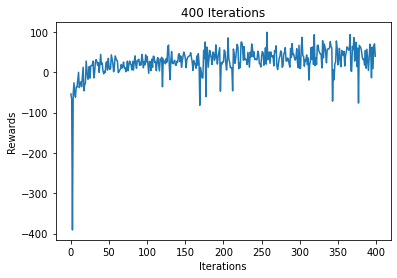

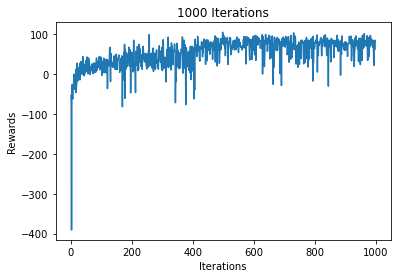

In [5]:
with open('analytics_data.json') as fp:
    json_data = json.load(fp)

def plot_curve_iter(_data, _desc):
    x = [v[1] for v in _data]
    y = [v[0] for v in _data]

    # Plot X and Y
    plt.plot(y, x)
    plt.title(_desc)
    plt.xlabel("Iterations")
    plt.ylabel("Rewards")
    plt.show()

plot_curve_iter(json_data["400Epochs"], "400 Iterations")
plot_curve_iter(json_data["allEpochs"], "1000 Iterations")